In [1]:
# install and restart run time 
!pip install -U albumentations
!pip install ttach

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


### Clone from repository

In [2]:
!git clone "https://github.com/jacobgil/pytorch-grad-cam.git"
!git clone "https://github.com/vvshankar78/DeepLearning.git"

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.
fatal: destination path 'DeepLearning' already exists and is not an empty directory.


In [3]:
import sys, os

my_path = 'DeepLearning/Extensive VisionAI-EVA6/08_Resnet'
sys.path.append(my_path)
# os.listdir(my_path)

my_path_cam = '/content/pytorch-grad-cam'
sys.path.append(my_path_cam)

In [4]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [6]:
# from model import Net2
from models import Resnet
from models import my_model
from train import train
from test1 import test
from config import ModelConfig
from utils import *
from data.data_engine import DataEngine

In [7]:
# import cv2
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.image import show_cam_on_image, \
#                                          deprocess_image, \
#                                          preprocess_image




In [8]:
# View model config
args = ModelConfig()
args.dropout_value = 0.0
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


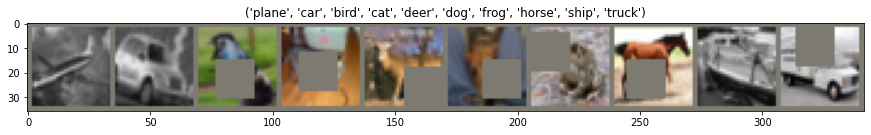

In [9]:
data = DataEngine(args)
data.show_samples()

In [10]:
train_loader = data.train_loader
test_loader = data.test_loader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [11]:
# Input parameters for the model
EPOCHS = 1
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)

# Run model for first 20 epochs with high rate, and half it thereafter
# model = Net2(args).to(device)
model = Resnet.ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Resnet18'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=1.6386950016021729 Batch_id=781 Accuracy=41.94: 100%|██████████| 782/782 [00:38<00:00, 20.42it/s]

length of Average loss 782, length of Average accuracy 782

learning rate 0.01


Test set: Average loss: 0.0192, Accuracy: 5669/10000 (56.69%)



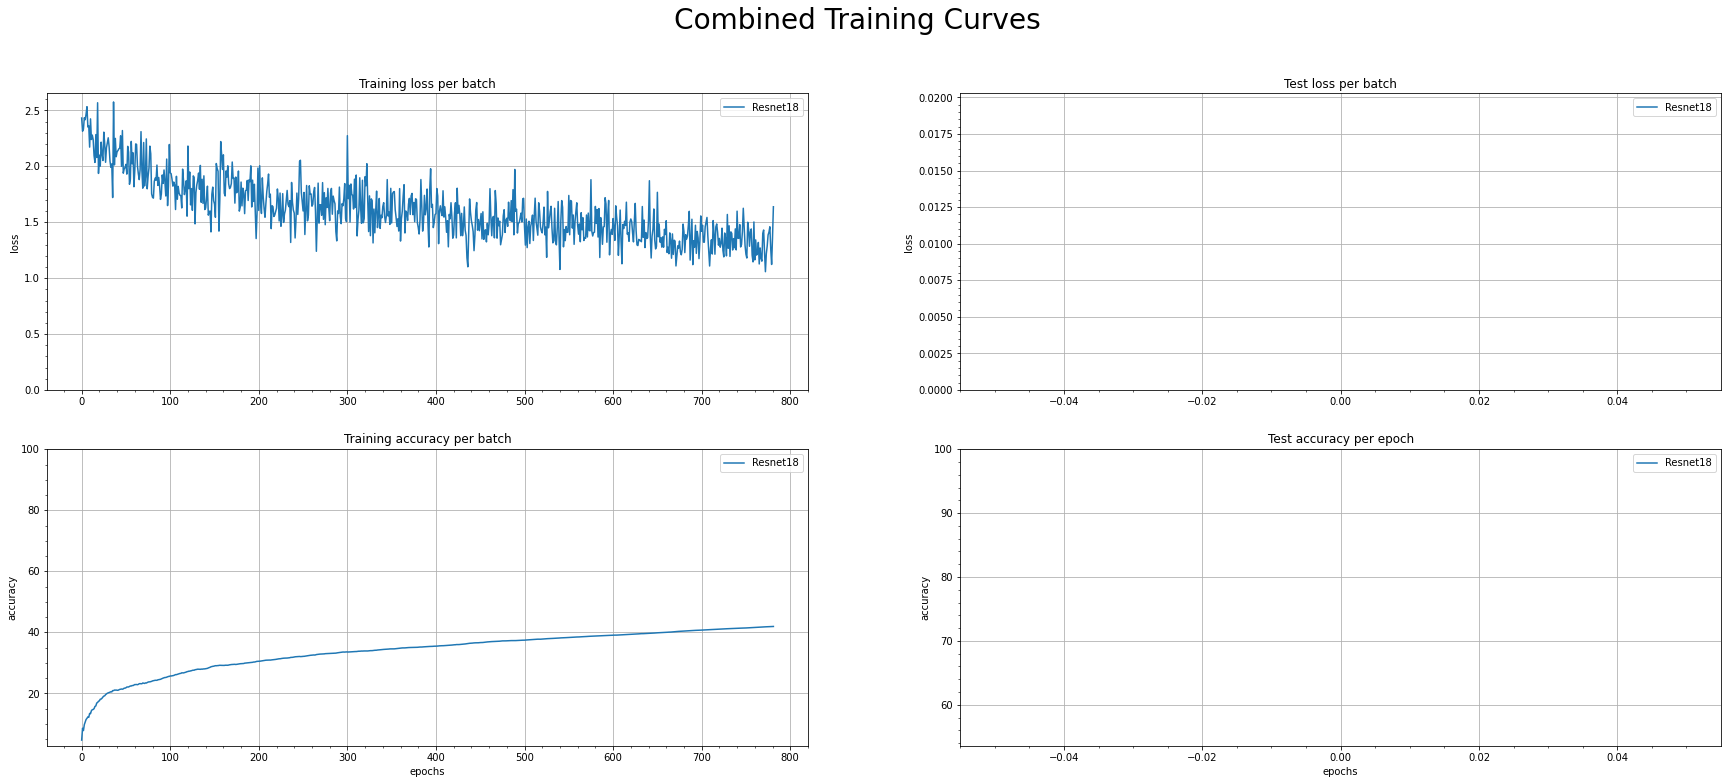

In [12]:
training_curves(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


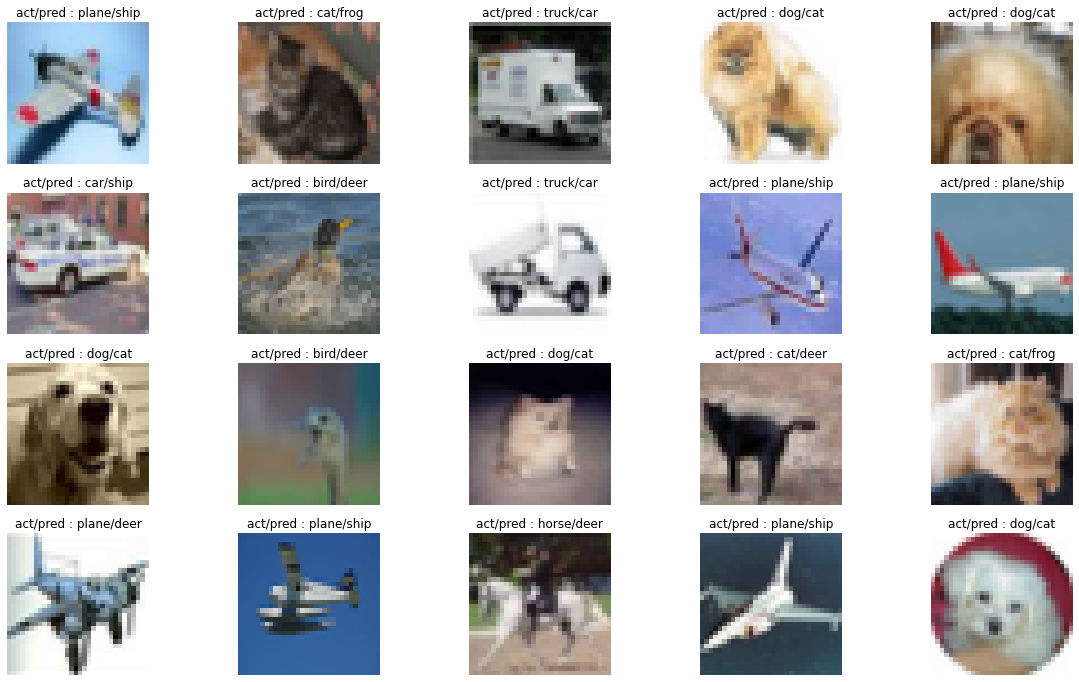

In [13]:
misclass_img_list, misclass_img_category = show_misclassified(model, test_loader, device, classes, num_of_images=20)

In [14]:
save_misclassified_img(misclass_img_list)

mis_img1.jpeg
mis_img2.jpeg
mis_img3.jpeg
mis_img4.jpeg
mis_img5.jpeg
mis_img6.jpeg
mis_img7.jpeg
mis_img8.jpeg
mis_img9.jpeg
mis_img10.jpeg
mis_img11.jpeg
mis_img12.jpeg
mis_img13.jpeg
mis_img14.jpeg
mis_img15.jpeg
mis_img16.jpeg
mis_img17.jpeg
mis_img18.jpeg
mis_img19.jpeg
mis_img20.jpeg


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/content/pytorch-grad-cam/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


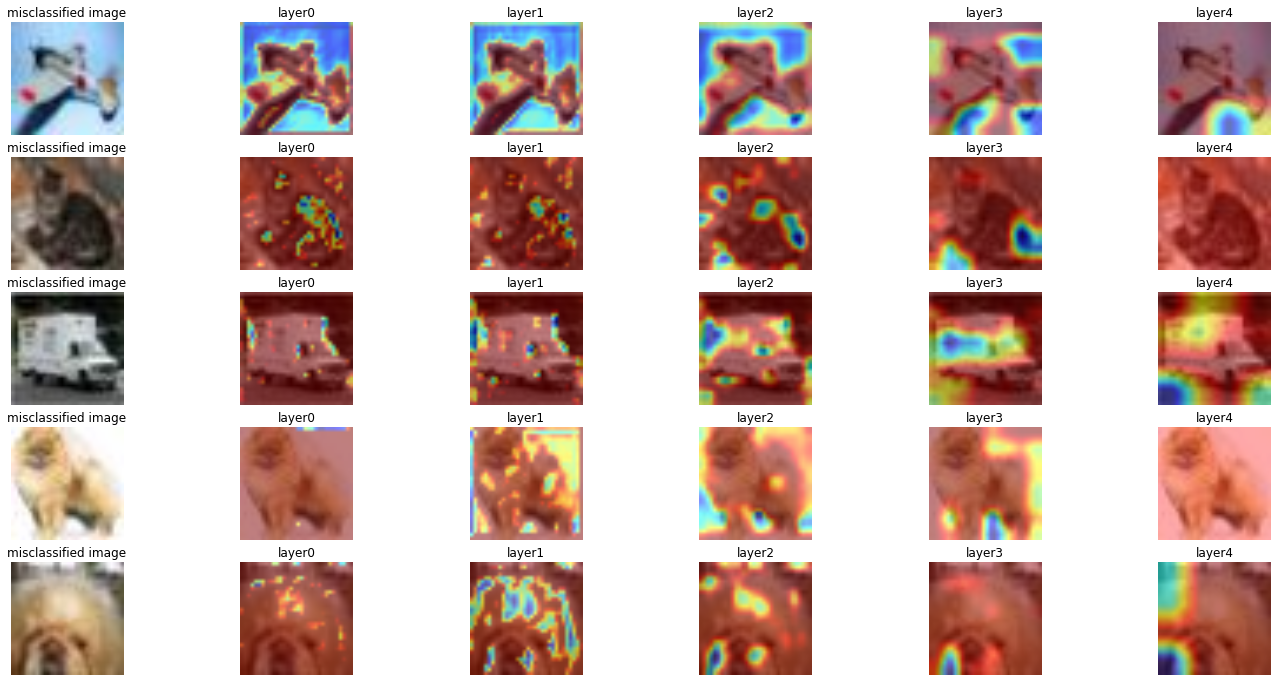

In [17]:
visualization = Generate_CAM(model, misclass_img_category, 20, cuda)
CAM_show_image(visualization, 0)

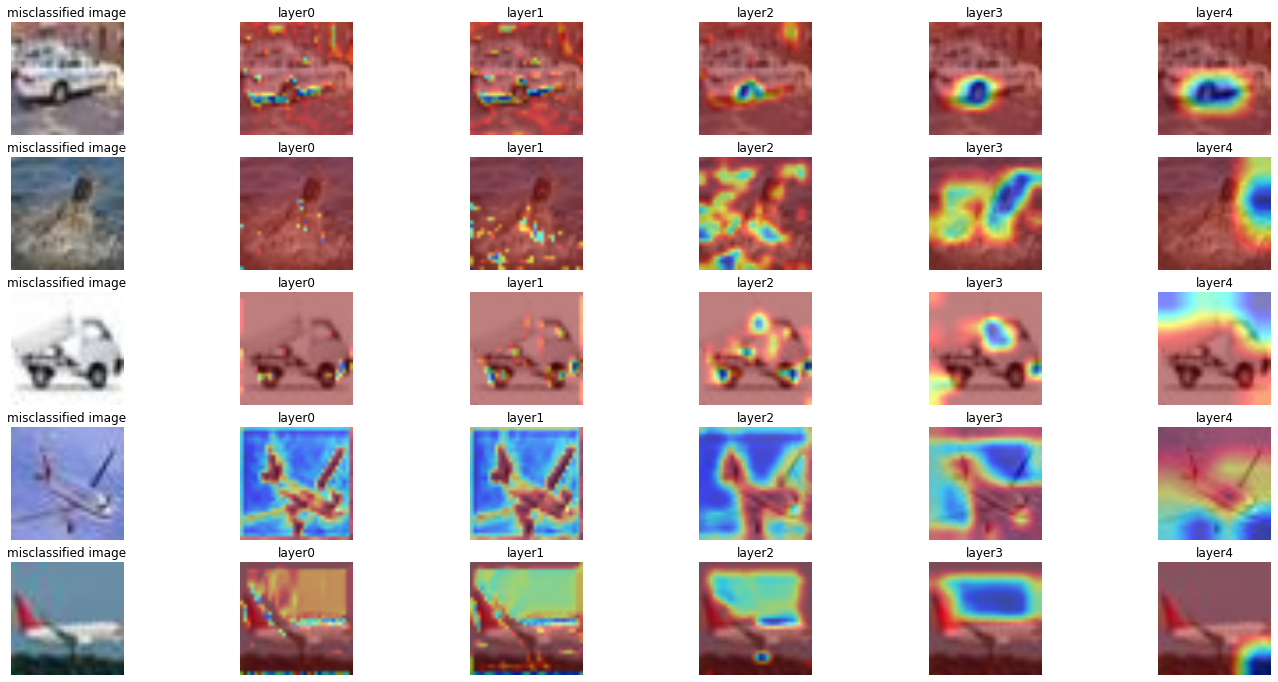

In [18]:
CAM_show_image(visualization, 30)

In [ ]:


# def imshow1(img):
# 	img = denormalize(img)
# 	npimg = img.numpy()
# 	plt.imshow(np.transpose(npimg, (1, 2, 0)))
# 	plt.grid(b=None)
# 	return img


# def show_misclassified(model, test_loader, num_of_images=10, )
#   model.eval()
#   figure = plt.figure(figsize=(20, 12))
#   num_of_images = 10
#   index = 1

#   misclass_img_list = []
#   misclass_img_category = []
#   untrans_img=[]

#   with torch.no_grad():
#       for data, target in test_loader:
#           data, target = data.to(
#               device), target.to(device)
#           output = model(data)
#           pred = output.argmax(dim=1, keepdim=True)
#           act = target.view_as(pred)
#           # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
#           bool_vec = ~pred.eq(act)

#           # now extract the index number from the tensor which has 'true'
#           idx = list(
#               np.where(bool_vec.cpu().numpy())[0])

#           if idx:  # if not a blank list
#               idx_list = idx
#               # print(data[idx_list[0]].shape)
#               if index < num_of_images+1:
#                   plt.subplot(2, 5, index)
#                   plt.axis('off')
#                   titl = 'act/pred : ' + \
#                       str(classes[target[idx[0]].cpu().item(
#                       )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
#                   # prints the 1st index of each batch.
              
#                   img = data[idx[0]].cpu()
#                   untrans_img.append(img)
#                   image = imshow1(img)
#                   misclass_img_list.append(image)
#                   misclass_img_category.append(target[idx[0]].cpu().item())
                                    
#                   plt.title(titl)
#                   index += 1
#   return misclass_img_list


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


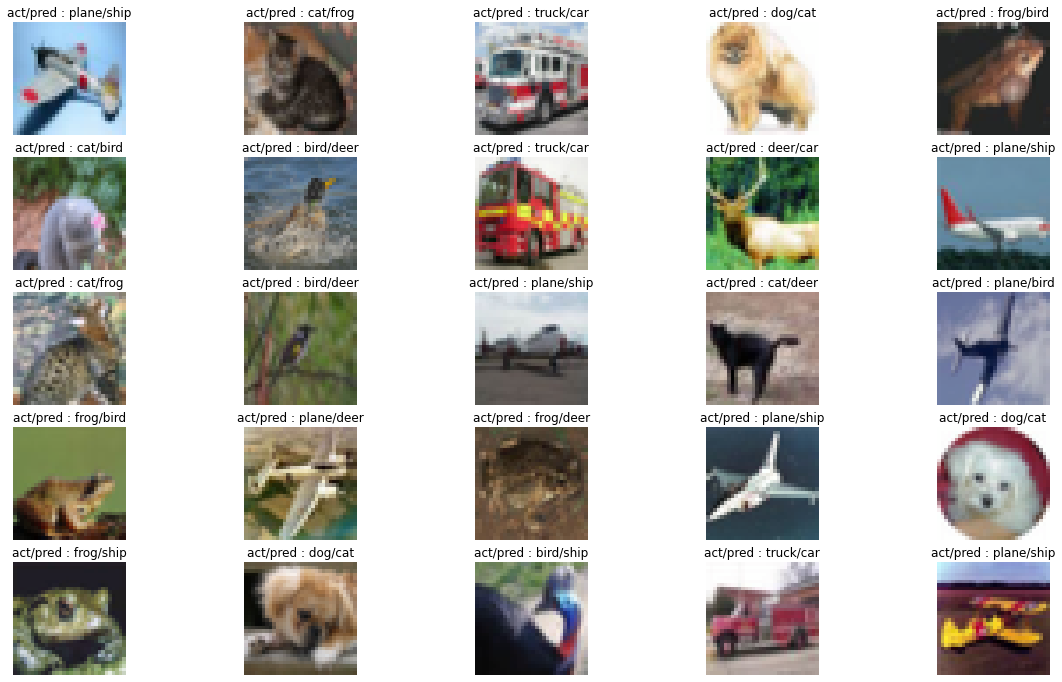

In [13]:
# def imshow1(img):
# 	img = denormalize(img)
# 	npimg = img.numpy()
# 	plt.imshow(np.transpose(npimg, (1, 2, 0)))
# 	plt.grid(b=None)
# 	return img

# #classes = data.classes

# model.eval()
# figure = plt.figure(figsize=(20, 12))
# num_of_images = 10
# index = 1

# misclass_img_list = []
# misclass_img_category = []
# untrans_img=[]

# with torch.no_grad():
#     for data, target in test_loader:
#         data, target = data.to(
#             device), target.to(device)
#         output = model(data)
#         pred = output.argmax(dim=1, keepdim=True)
#         act = target.view_as(pred)
#         # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
#         bool_vec = ~pred.eq(act)

#         # now extract the index number from the tensor which has 'true'
#         idx = list(
#             np.where(bool_vec.cpu().numpy())[0])

#         if idx:  # if not a blank list
#             idx_list = idx
#             # print(data[idx_list[0]].shape)
#             if index < num_of_images+1:
#                 plt.subplot(2, 5, index)
#                 plt.axis('off')
#                 titl = 'act/pred : ' + \
#                     str(classes[target[idx[0]].cpu().item(
#                     )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
#                 # prints the 1st index of each batch.
            
#                 img = data[idx[0]].cpu()
#                 untrans_img.append(img)
#                 image = imshow1(img)
#                 misclass_img_list.append(image)
#                 misclass_img_category.append(target[idx[0]].cpu().item())
                                  
#                 plt.title(titl)
#                 index += 1



mis_img1.jpeg
mis_img2.jpeg
mis_img3.jpeg
mis_img4.jpeg
mis_img5.jpeg
mis_img6.jpeg
mis_img7.jpeg
mis_img8.jpeg
mis_img9.jpeg
mis_img10.jpeg


In [ ]:
# def save_misclassified_img(misclass_img_list):
#   mis_img_name_list = []

#   for i in range(len(misclass_img_list)):
#     # img_name = 'images/'+'mis_img'+str(i+1)+'.jpeg'
#     img_name = 'mis_img'+str(i+1)+'.jpeg'
#     mis_img_name_list.append(img_name)
#     image = (255*torch.swapaxes(misclass_img_list[i], 0, 2))
#     image = torch.swapaxes(image, 0, 1)
#     image = image.type(torch.uint8).cpu().numpy()
#     #print(image.shape)
#     matplotlib.image.imsave(img_name, image)
#     # print(img_name)


In [14]:
# mis_img_name_list = []

# for i in range(len(misclass_img_list)):
#   # img_name = 'images/'+'mis_img'+str(i+1)+'.jpeg'
#   img_name = 'mis_img'+str(i+1)+'.jpeg'
#   mis_img_name_list.append(img_name)
#   image = (255*torch.swapaxes(misclass_img_list[i], 0, 2))
#   image = torch.swapaxes(image, 0, 1)
#   image = image.type(torch.uint8).cpu().numpy()
#   #print(image.shape)
#   matplotlib.image.imsave(img_name, image)
#   # print(img_name)

### The Receptive Field of 7x7 is achieved in the middle of layer1, so we keep that as first

NameError: ignored

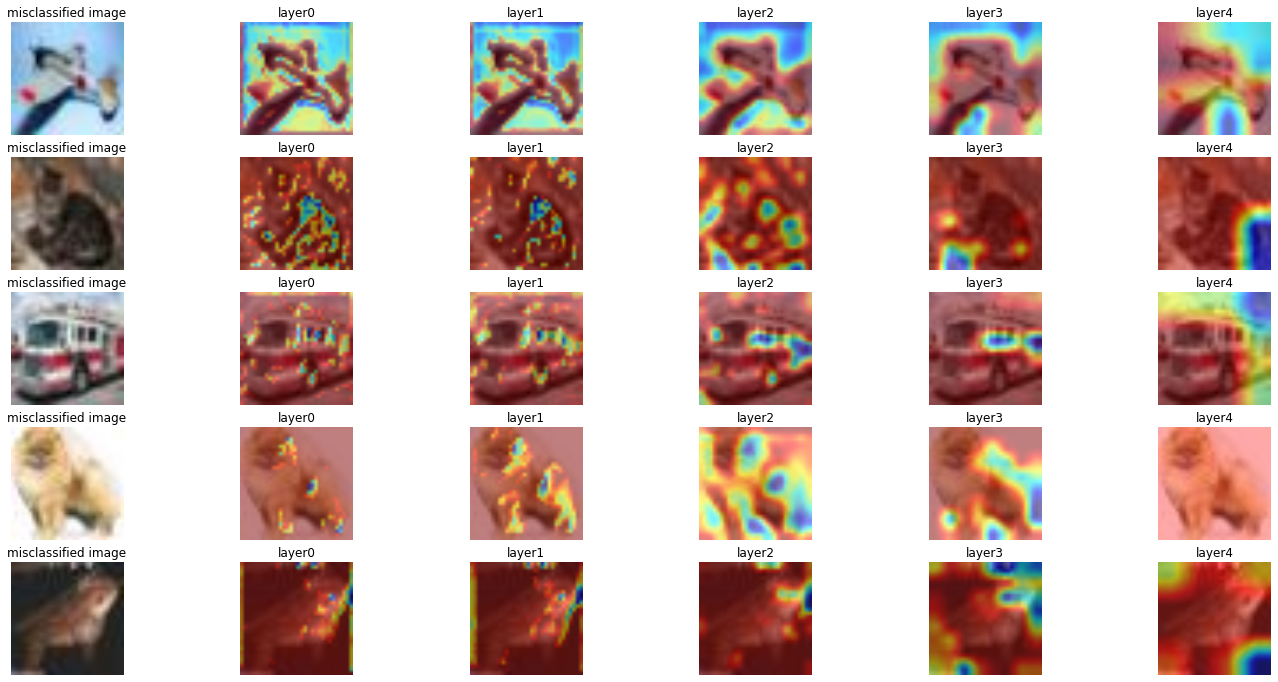

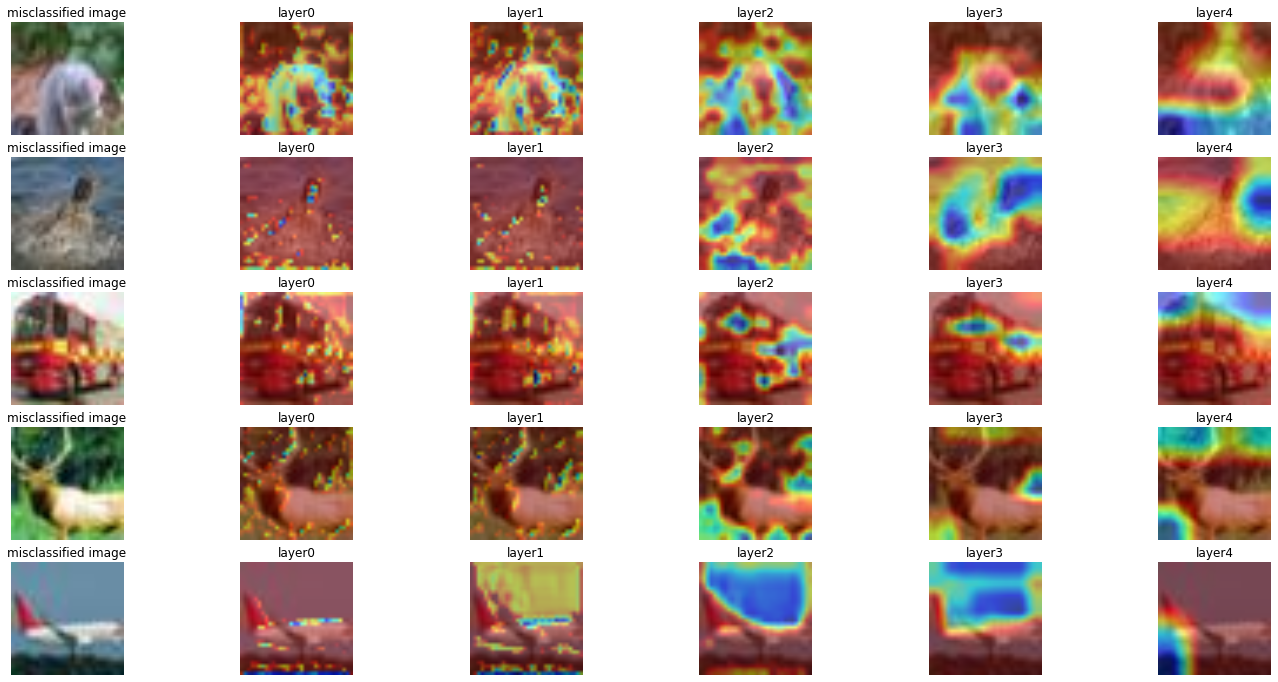

In [17]:
CAM_show_image(visualization, 30)

In [16]:
show_image(visualization, 0)

NameError: ignored

In [18]:
# def Generate_CAM(model, misclass_img_category, misclass_count):
#   target_layer0 = model.layer1[0]    #RF 7x7
#   target_layer1 = model.layer1[-1]   #rest are the end of respective layers
#   target_layer2 = model.layer2[-1]
#   target_layer3 = model.layer3[-1]
#   target_layer4 = model.layer4[-1]

#   visualization = []   #store all the grad cam images here
#   rgb_img_list = []

#   missclassified_count = misclass_count

#   for i in range(0, missclassified_count-1):
      
#       # image_path = 'images/mis_img' + str(i+1) + '.jpeg'
#       image_path = 'mis_img' + str(i+1) + '.jpeg'
#       rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
#       #rgb_img = cv2.resize(rgb_img, (224, 224))    #uncomment this to scale to 224x224
#       rgb_img = np.float32(rgb_img) / 255
#       input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#       rgb_img_list.append(rgb_img)
      
#       target_category = misclass_img_category[i]
#       visualization.append(rgb_img)

#       for layer in [target_layer0, target_layer1, target_layer2, target_layer3, target_layer4]:
#           cam = GradCAM(model=model, target_layer=layer, use_cuda=cuda)
#           grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
#           grayscale_cam = grayscale_cam[0, :]
          
#           visualization.append(show_cam_on_image(rgb_img, grayscale_cam))
#   return visualization

NameError: ignored

In [18]:
# target_layer0 = model.layer1[0]    #RF 7x7
# target_layer1 = model.layer1[-1]   #rest are the end of respective layers
# target_layer2 = model.layer2[-1]
# target_layer3 = model.layer3[-1]
# target_layer4 = model.layer4[-1]

# visualization = []   #store all the grad cam images here
# rgb_img_list = []

# missclassified_count = 10

# for i in range(0, missclassified_count-1):
    
#     # image_path = 'images/mis_img' + str(i+1) + '.jpeg'
#     image_path = 'mis_img' + str(i+1) + '.jpeg'
#     rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
#     #rgb_img = cv2.resize(rgb_img, (224, 224))    #uncomment this to scale to 224x224
#     rgb_img = np.float32(rgb_img) / 255
#     input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     rgb_img_list.append(rgb_img)
    
#     target_category = misclass_img_category[i]
#     visualization.append(rgb_img)

#     for layer in [target_layer0, target_layer1, target_layer2, target_layer3, target_layer4]:
#         cam = GradCAM(model=model, target_layer=layer, use_cuda=cuda)
#         grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
#         grayscale_cam = grayscale_cam[0, :]
        
#         visualization.append(show_cam_on_image(rgb_img, grayscale_cam))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/content/pytorch-grad-cam/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


In [16]:

# def CAM_show_image(visualization, start_image):

#   plt.rcParams['figure.figsize'] = [24, 12]
#   plt.figure(1)
#   cnt=1
#   layer_no=0
#   # start_image = 48
#   for i in range(1, 31):
#       # plt.subplot(int(len(visualization)/6), 6, i)
#       plt.subplot(5, 6, i)
#       plt.imshow(visualization[start_image], interpolation='bilinear')
#       start_image+=1
#       plt.axis('off')
#       if cnt==1:
#         plt.title('misclassified image')
#       else:
#         plt.title ('layer'+ str(layer_no))
#         layer_no+=1
#       if cnt== 6:
#         cnt =0
#         layer_no = 0
#       cnt+=1


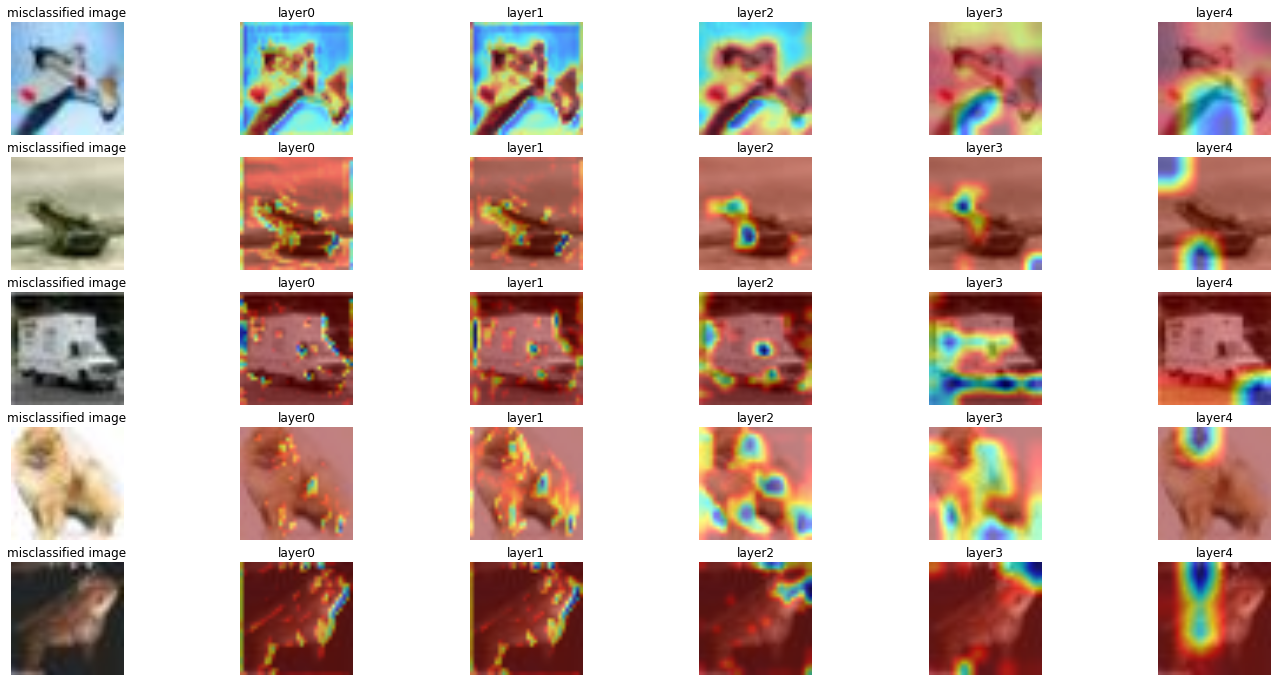

In [17]:
show_image(visualization, 0)

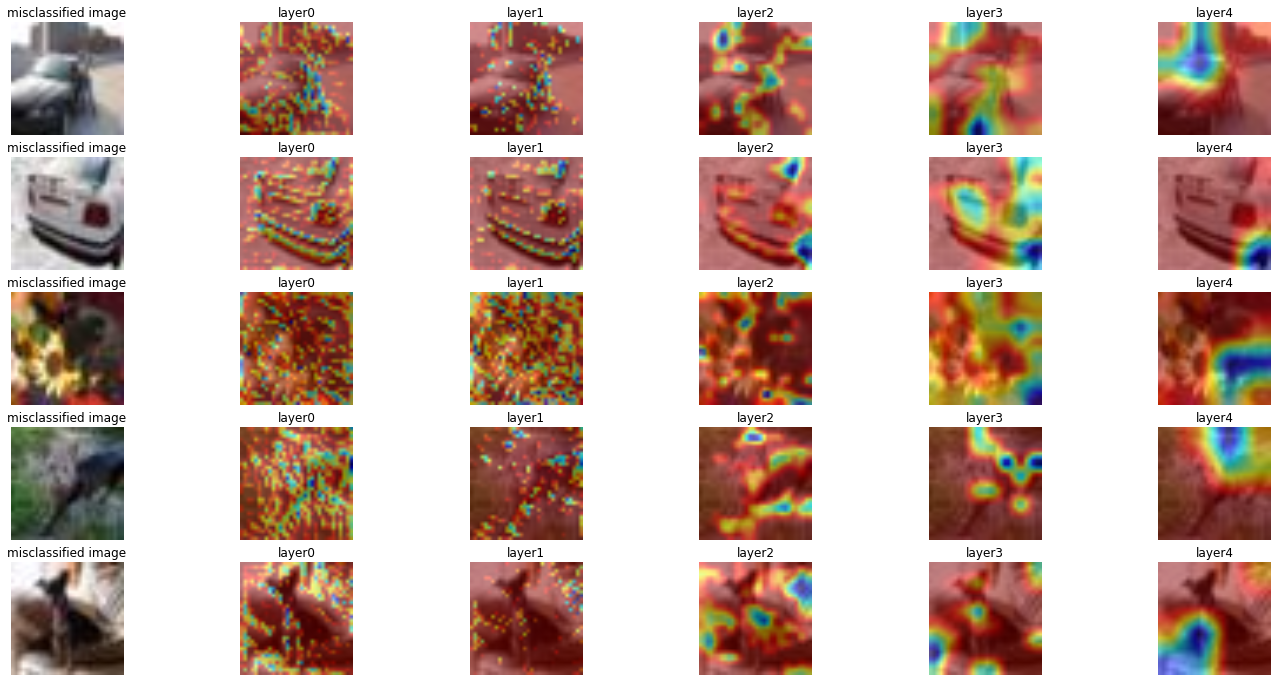

In [32]:
show_image(visualization, 30)

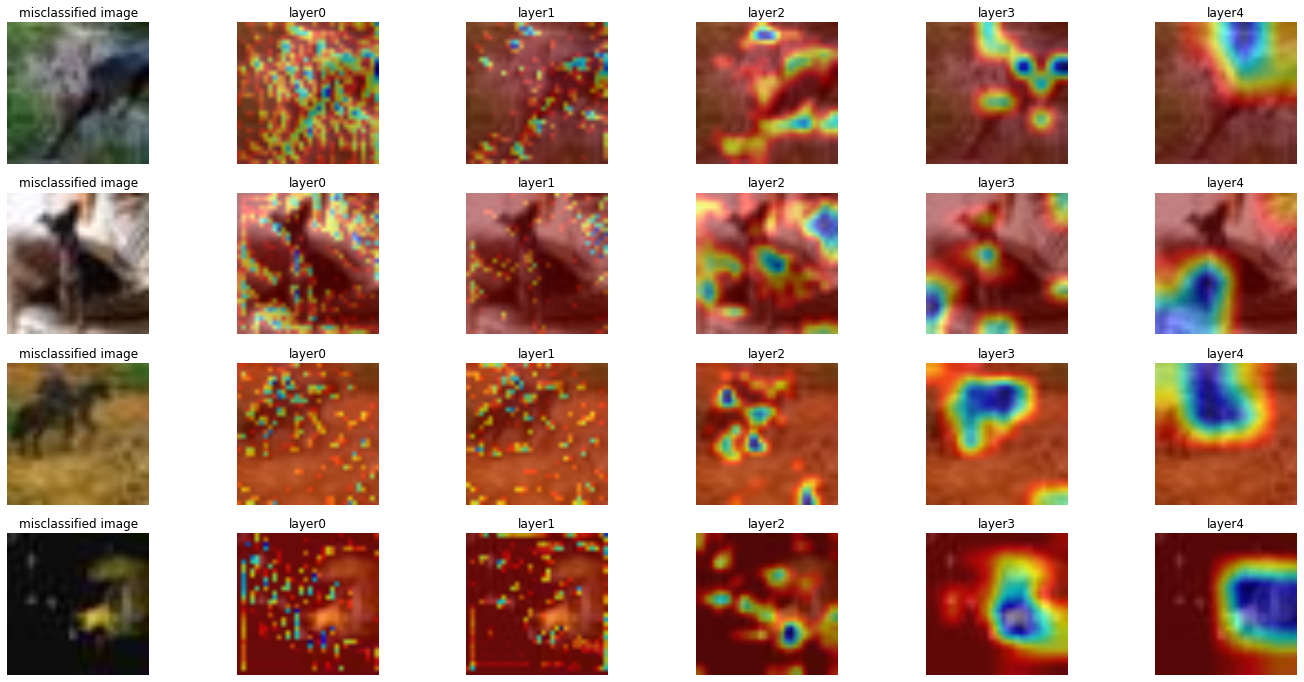

In [22]:
show_image(visualization, 48)

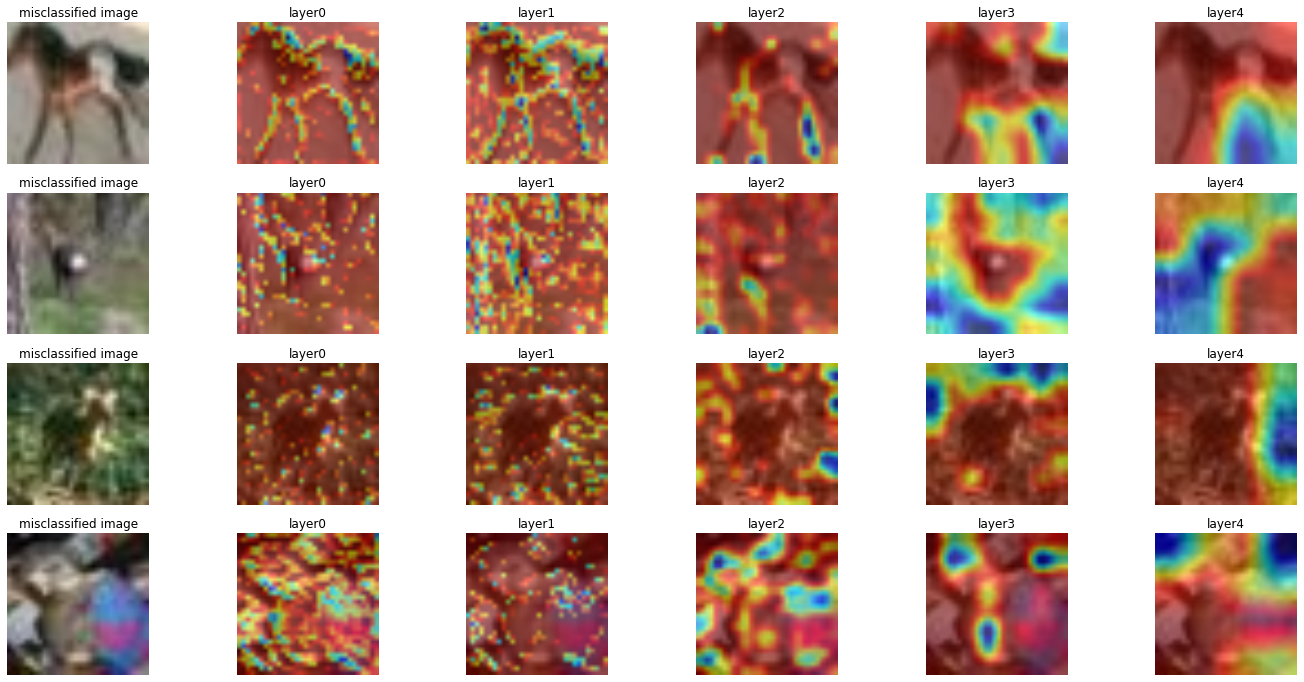

In [23]:
show_image(visualization, 72)

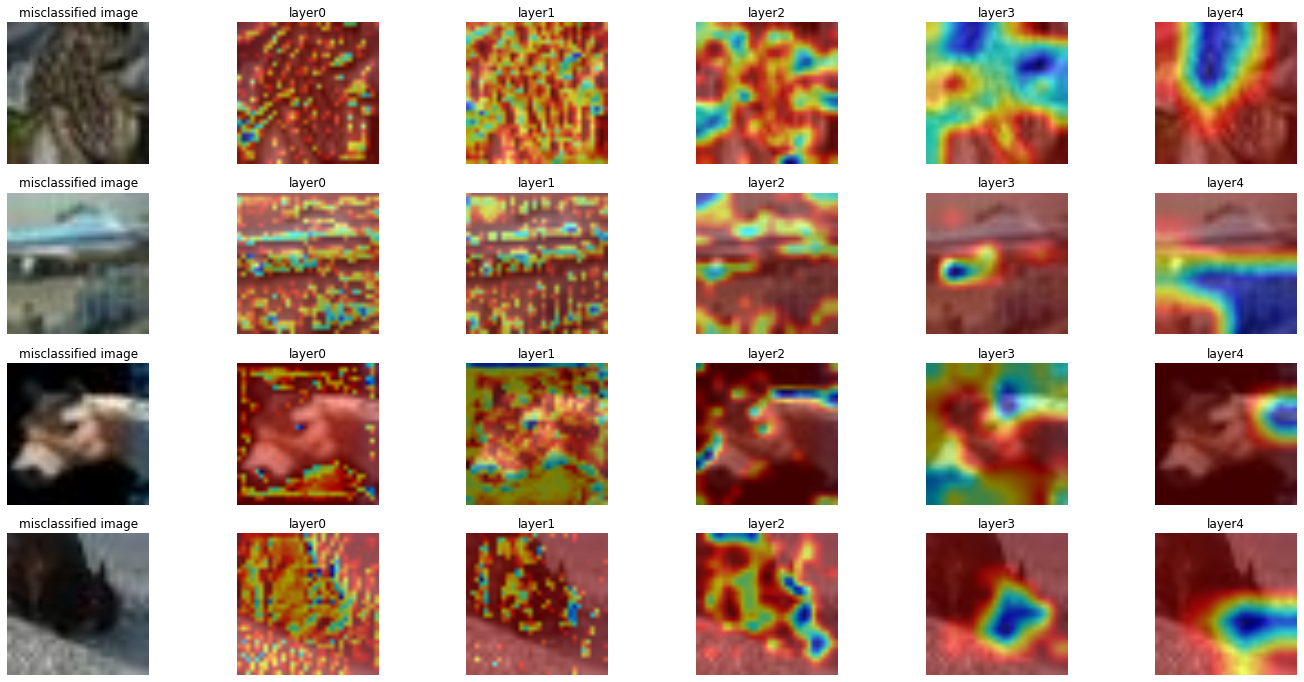

In [24]:
show_image(visualization, 96)

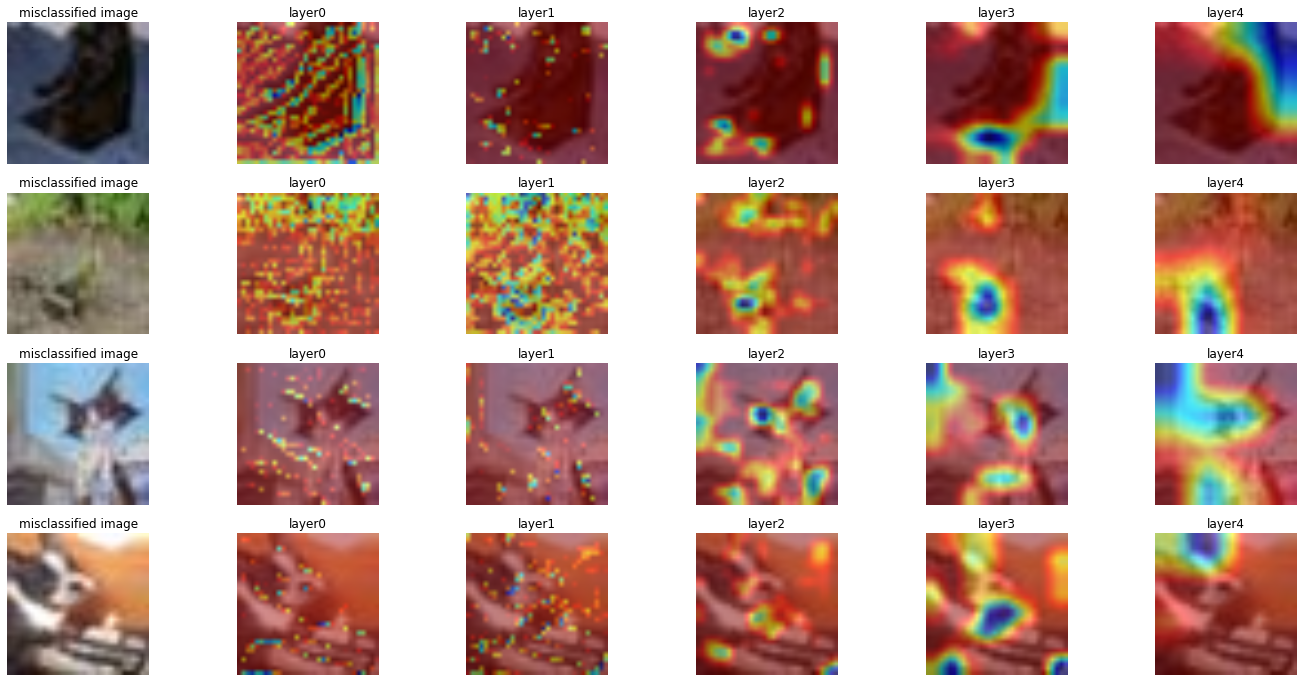

In [25]:
show_image(visualization, 120)